<a href="https://colab.research.google.com/github/MasudRana2406/Integrating-Demand-Forecasting-and-Inventory-Optimization/blob/main/Integration_Retail_Demand_Forecasting_%26_Inventory_Optimization_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Title**: Integrating Retail Demand Forecasting and Inventory Optimization to Enhance Supply Chain Efficiency



## Install & Import Necessary Libraries

In [ ]:
# Install catboost, optuna

!pip install catboost
!pip install optuna

In [ ]:
# Core Python & utilities
import os
import random
import warnings
warnings.filterwarnings("ignore")

# Numerical & data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Scikit-learn preprocessing & metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

# Gradient boosting models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, Booster
from catboost import CatBoostRegressor

# Hyperparameter optimization & model persistence
import optuna
import joblib
import json

# Deep learning (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Time series models
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX


## Load Dataset

In [ ]:
# Drive Mounting

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check  files in folder

datasets_list = os.listdir('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy')

for files in datasets_list:
  print(files)

sales_train_evaluation.csv
sell_prices.csv
sales_train_validation.csv
calendar.csv
sample_submission.csv
sales_merge_dataset.csv


**Note:**
1. sales_train_validation.csv is the main dataset for time-series modelling which contains daily unit sales for each item–store combination.

2. sell_prices.csv contains historical prices for each item–store which is needed to understand price elasticity

3. calendar.csv contains date-level attributes such as events, SNAP, weekdays, month, year which useful for adding event features, capturing seasonality, understanding demand spikes.

4. Skipping sales_train_evaluation.csv and sample_submission.csv because they are competition-specific files not needed for training, validation, or analysis.

In [ ]:
# Load my required dateset

path = '/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy'


sales = pd.read_csv(os.path.join(path, 'sales_train_validation.csv'))
calendar = pd.read_csv(os.path.join(path, 'calendar.csv'))
prices = pd.read_csv(os.path.join(path, 'sell_prices.csv'))

print("Sales shape:", sales.shape)
print("Calendar shape:", calendar.shape)
print("Prices shape:", prices.shape)

Sales shape: (30490, 1919)
Calendar shape: (1969, 14)
Prices shape: (6841121, 4)


In [ ]:
# Check Sales dataset
sales.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [ ]:
# Check DataFrame’s structure

sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


Insights:
* It’s a wide dataset with mostly numeric daily sales data and a few categorical identifiers.

In [ ]:
# Check Missing Values

missing_data = sales.isnull().sum()
missing_data[missing_data > 0]

,0


Insights:
* There is not missing value in sales dataset

In [ ]:
# Check unique values in column except day column
for col in sales.columns:
  if not col.startswith('d_'):
    print(f"{col}: {sales[col].nunique()}")


id: 30490
item_id: 3049
dept_id: 7
cat_id: 3
store_id: 10
state_id: 3


**Note:**
* It is large dataset,so I will select one store & one product department for my project


In [ ]:
# Check statistical Summary

sales.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,...,1.370581,1.586159,1.693670,1.248245,1.232207,1.159167,1.149000,1.328862,1.605838,1.633158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,...,3.740017,4.097191,4.359809,3.276925,3.125471,2.876026,2.950364,3.358012,4.089422,3.812248
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,360.000000,436.000000,207.000000,323.000000,296.000000,314.000000,316.000000,370.000000,385.000000,353.000000,...,129.000000,160.000000,204.000000,98.000000,100.000000,88.000000,77.000000,141.000000,171.000000,130.000000


In [ ]:
# Check for duplicates

print(sales.duplicated().sum())

0


In [ ]:
# Check count the frequency of unique values of state_ID

sales['state_id'].value_counts()

,count
state_id,
CA,12196
TX,9147
WI,9147


In [ ]:
# Check count the frequency of unique values of store_id

sales['store_id'].value_counts()

,count
store_id,
CA_1,3049
CA_2,3049
CA_3,3049
CA_4,3049
TX_1,3049
TX_2,3049
TX_3,3049
WI_1,3049
WI_2,3049


In [ ]:
# Check count the frequency of unique values of cat_id

sales['cat_id'].value_counts()

,count
cat_id,
FOODS,14370
HOUSEHOLD,10470
HOBBIES,5650


In [ ]:
# Check count the frequency of unique values of dept_id

sales['dept_id'].value_counts()

,count
dept_id,
FOODS_3,8230
HOUSEHOLD_1,5320
HOUSEHOLD_2,5150
HOBBIES_1,4160
FOODS_2,3980
FOODS_1,2160
HOBBIES_2,1490


In [ ]:
# Check unique values

print(sales['state_id'].unique())
print(sales['store_id'].unique())
print(sales['cat_id'].unique())

['CA' 'TX' 'WI']
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
['HOBBIES' 'HOUSEHOLD' 'FOODS']


## Creating subset for demonstration

In [ ]:
# Creating dataset with product selling minimum 10 per day(considering day 1)

sales_filtered = sales[sales['d_1']> 10]

In [ ]:
print(sales_filtered['state_id'].value_counts(),'\n')

print(sales_filtered['store_id'].value_counts(),'\n')

print(sales_filtered['cat_id'].value_counts(),'\n')

print(sales_filtered['dept_id'].value_counts(),'\n')

state_id
CA    268
WI    172
TX    145
Name: count, dtype: int64 

store_id
CA_3    91
CA_1    84
CA_2    82
WI_3    77
TX_2    67
WI_1    54
WI_2    41
TX_1    39
TX_3    39
CA_4    11
Name: count, dtype: int64 

cat_id
FOODS        449
HOBBIES       69
HOUSEHOLD     67
Name: count, dtype: int64 

dept_id
FOODS_3        349
FOODS_2         70
HOBBIES_1       69
HOUSEHOLD_1     65
FOODS_1         30
HOUSEHOLD_2      2
Name: count, dtype: int64 



In [ ]:
# Creating subset by filtering to state, store, category

sales_subset = sales_filtered[(sales_filtered["state_id"] == "WI") & (sales_filtered["store_id"] == "WI_3") & (sales_filtered["cat_id"] == "FOODS") & (sales_filtered["dept_id"] == "FOODS_2")]
sales_subset

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
29289,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,29,24,12,40,...,0,0,2,0,0,0,1,0,0,0
29395,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,13,8,19,8,...,7,4,5,5,3,8,2,2,5,3
29419,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,12,10,9,6,...,4,2,6,4,4,1,3,7,1,5
29431,FOODS_2_164_WI_3_validation,FOODS_2_164,FOODS_2,FOODS,WI_3,WI,12,10,12,7,...,6,15,4,0,2,0,2,9,3,2
29448,FOODS_2_181_WI_3_validation,FOODS_2_181,FOODS_2,FOODS,WI_3,WI,15,26,23,19,...,13,17,26,10,10,5,9,11,8,4
29500,FOODS_2_233_WI_3_validation,FOODS_2_233,FOODS_2,FOODS,WI_3,WI,12,6,4,8,...,6,7,5,3,1,6,8,5,3,4
29543,FOODS_2_276_WI_3_validation,FOODS_2_276,FOODS_2,FOODS,WI_3,WI,22,25,20,13,...,2,9,3,10,6,4,7,4,7,9
29627,FOODS_2_360_WI_3_validation,FOODS_2_360,FOODS_2,FOODS,WI_3,WI,26,22,18,3,...,27,16,11,12,6,19,25,17,14,6
29631,FOODS_2_364_WI_3_validation,FOODS_2_364,FOODS_2,FOODS,WI_3,WI,28,34,38,59,...,5,6,7,1,5,1,3,4,2,5
29665,FOODS_2_398_WI_3_validation,FOODS_2_398,FOODS_2,FOODS,WI_3,WI,11,15,12,14,...,8,16,7,5,3,18,5,9,3,4


In [ ]:
# Check shape of dataset

sales_subset.shape

(10, 1919)

In [ ]:
# Re-Check unique values in column except day column

for col in sales_subset.columns:
  if not col.startswith('d_'):
    print(f"{col}: {sales_subset[col].nunique()}")

id: 10
item_id: 10
dept_id: 1
cat_id: 1
store_id: 1
state_id: 1


## Transforming Sales Data: Wide to Long Format

In [ ]:
# Melt the sales data from wide (d_1, d_2…) to long format

id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sales_long = pd.melt(sales_subset,id_vars=id_vars,var_name="d",value_name="sales")
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12


In [ ]:
# Check data structure

sales_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19130 entries, 0 to 19129
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        19130 non-null  object
 1   item_id   19130 non-null  object
 2   dept_id   19130 non-null  object
 3   cat_id    19130 non-null  object
 4   store_id  19130 non-null  object
 5   state_id  19130 non-null  object
 6   d         19130 non-null  object
 7   sales     19130 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 1.2+ MB


In [ ]:
# Convert the "d" column (like "d_1", "d_2") into a numeric day index

sales_long["day_number"] = sales_long["d"].str.extract(r"_(\d+)").astype(int)
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29,1
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13,1
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12,1


**Note:**

The \d+ in the regular expression means “match one or more digits”.

\d → matches any single digit (0–9)

'+' → means “one or more times”

So \d+ will match numbers like 1, 12, 1913, etc.

In [ ]:
# Check calendar dataset

calendar.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
# Merge with calendar by "d" column that matches the "d" in sales_long

sales_long = sales_long.merge(calendar, how="left", on="d")
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29,1,2011-01-29,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13,1,2011-01-29,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12,1,2011-01-29,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
# Check prices dataset

prices.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


In [ ]:
# Merge with prices by wm_yr_wk

sales_long = sales_long.merge(prices,on=["store_id", "item_id", "wm_yr_wk"],how="left")
sales_long.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,FOODS_2_021_WI_3_validation,FOODS_2_021,FOODS_2,FOODS,WI_3,WI,d_1,29,1,2011-01-29,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.64
1,FOODS_2_128_WI_3_validation,FOODS_2_128,FOODS_2,FOODS,WI_3,WI,d_1,13,1,2011-01-29,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.64
2,FOODS_2_152_WI_3_validation,FOODS_2_152,FOODS_2,FOODS,WI_3,WI,d_1,12,1,2011-01-29,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,1.98


**Note:**

If I merged only on wm_yr_wk, I could get:

Prices from a different item in the same week or

Prices from a different store in the same week

So , I used "store_id", "item_id", "wm_yr_wk"

In [ ]:
# Check final columns  name

sales_long.keys()

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'day_number', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

## Basic overview with Final Dataset

In [ ]:
# Data structure of final dataset

sales_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19130 entries, 0 to 19129
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            19130 non-null  object 
 1   item_id       19130 non-null  object 
 2   dept_id       19130 non-null  object 
 3   cat_id        19130 non-null  object 
 4   store_id      19130 non-null  object 
 5   state_id      19130 non-null  object 
 6   d             19130 non-null  object 
 7   sales         19130 non-null  int64  
 8   day_number    19130 non-null  int64  
 9   date          19130 non-null  object 
 10  wm_yr_wk      19130 non-null  int64  
 11  weekday       19130 non-null  object 
 12  wday          19130 non-null  int64  
 13  month         19130 non-null  int64  
 14  year          19130 non-null  int64  
 15  event_name_1  1540 non-null   object 
 16  event_type_1  1540 non-null   object 
 17  event_name_2  40 non-null     object 
 18  event_type_2  40 non-null 

In [ ]:
# Check Statistical Summary

sales_long.describe()

,sales,day_number,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price
count,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000,19130.000000
mean,7.062520,957.000000,11339.191323,3.997386,6.357554,2013.209096,0.329326,0.329326,0.329326,2.254731
std,9.594391,552.249891,150.378111,2.000704,3.458864,1.532126,0.469981,0.469981,0.469981,1.122140
min,0.000000,1.000000,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000,0.640000
25%,0.000000,479.000000,11217.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000,0.940000
50%,4.000000,957.000000,11333.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000,2.420000
75%,10.000000,1435.000000,11448.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000,2.980000
max,83.000000,1913.000000,11613.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000,4.480000


In [ ]:
# Check shape of our final dataset

sales_long.shape

(19130, 23)

In [ ]:
# Missing values summary

missing_summary = sales_long.isnull().sum()
missing_summary[missing_summary > 0]

,0
event_name_1,17590
event_type_1,17590
event_name_2,19090
event_type_2,19090


In [ ]:
# Fill missing events with "No Event"

sales_long['event_name_1'].fillna('No Event', inplace=True)
sales_long['event_type_1'].fillna('No Event', inplace=True)
sales_long['event_name_2'].fillna('No Event', inplace=True)
sales_long['event_type_2'].fillna('No Event', inplace=True)

In [ ]:
# Recheck Missing values summary

missing_summary = sales_long.isnull().sum()
missing_summary[missing_summary > 0]

,0


In [ ]:
# Check any duplicated values

sales_long.duplicated().sum()

np.int64(0)

In [ ]:
# Check filtered dataset

sales_long.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,day_number,date,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
19125,FOODS_2_233_WI_3_validation,FOODS_2_233,FOODS_2,FOODS,WI_3,WI,d_1913,4,1913,2016-04-24,...,4,2016,No Event,No Event,No Event,No Event,0,0,0,4.48
19126,FOODS_2_276_WI_3_validation,FOODS_2_276,FOODS_2,FOODS,WI_3,WI,d_1913,9,1913,2016-04-24,...,4,2016,No Event,No Event,No Event,No Event,0,0,0,3.42
19127,FOODS_2_360_WI_3_validation,FOODS_2_360,FOODS_2,FOODS,WI_3,WI,d_1913,6,1913,2016-04-24,...,4,2016,No Event,No Event,No Event,No Event,0,0,0,0.94
19128,FOODS_2_364_WI_3_validation,FOODS_2_364,FOODS_2,FOODS,WI_3,WI,d_1913,5,1913,2016-04-24,...,4,2016,No Event,No Event,No Event,No Event,0,0,0,2.74
19129,FOODS_2_398_WI_3_validation,FOODS_2_398,FOODS_2,FOODS,WI_3,WI,d_1913,4,1913,2016-04-24,...,4,2016,No Event,No Event,No Event,No Event,0,0,0,2.43


In [ ]:
# Save final dataset

sales_long.to_csv('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy/sales_merge_dataset.csv', index=False)

## Load saved final dataset ( Store : WI_3, Dept : FOODS_2)

In [ ]:
# Load final dataset for EDA

Sales_df = pd.read_csv('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/m5-forecasting-accuracy/sales_merge_dataset.csv')

## Exploratory Data Analysis (EDA)



### Target Variable Analysis (Sales)

### Sales distribution

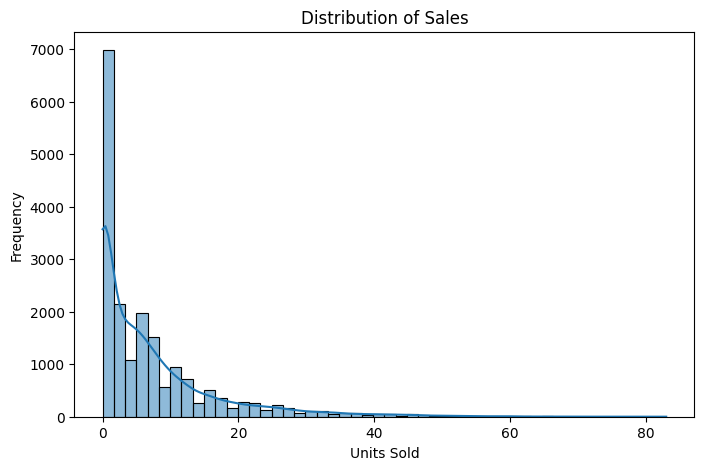

In [ ]:
# Distribution of sales

plt.figure(figsize=(8,5))
sns.histplot(Sales_df['sales'], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.xlabel("Units Sold")
plt.ylabel("Frequency")
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/distribution_of_sales.png")
plt.show()

### Zero-sales proportion (important for inventory risk)

In [ ]:
zero_ratio = (Sales_df['sales'] == 0).mean() * 100
print(f"Zero-sales days: {zero_ratio:.2f}%")

Zero-sales days: 31.90%


### Outlier detection

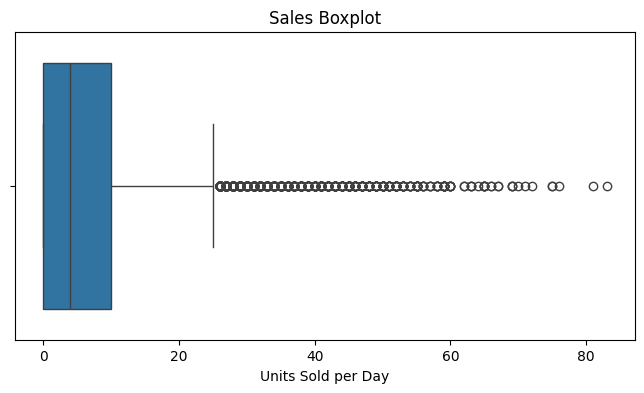

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(x='sales', data=Sales_df)
plt.title('Sales Boxplot')
plt.xlabel('Units Sold per Day')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/sales_boxplot.png")
plt.show()

## Time Series Behaviour (Trend & Seasonality)



In [ ]:
# Convert 'date' to datetime
Sales_df['date'] = pd.to_datetime(Sales_df['date'])

### Aggregate overall sales trend

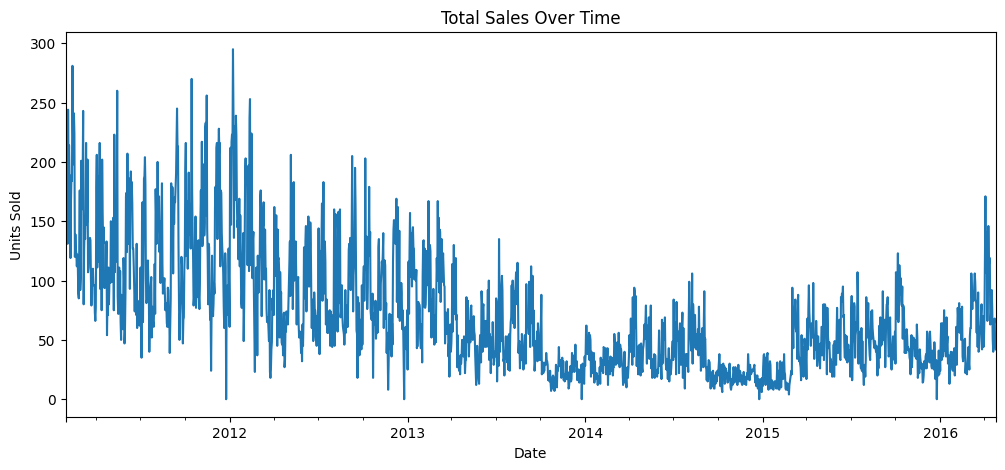

In [ ]:
# Aggregate sales by date and sort
daily_sales = Sales_df.groupby('date')['sales'].sum().sort_index()

# Plot
plt.figure(figsize=(12,5))
daily_sales.plot()
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/total_sales_over_time.png")
plt.show()

### Rolling mean (trend smoothing)

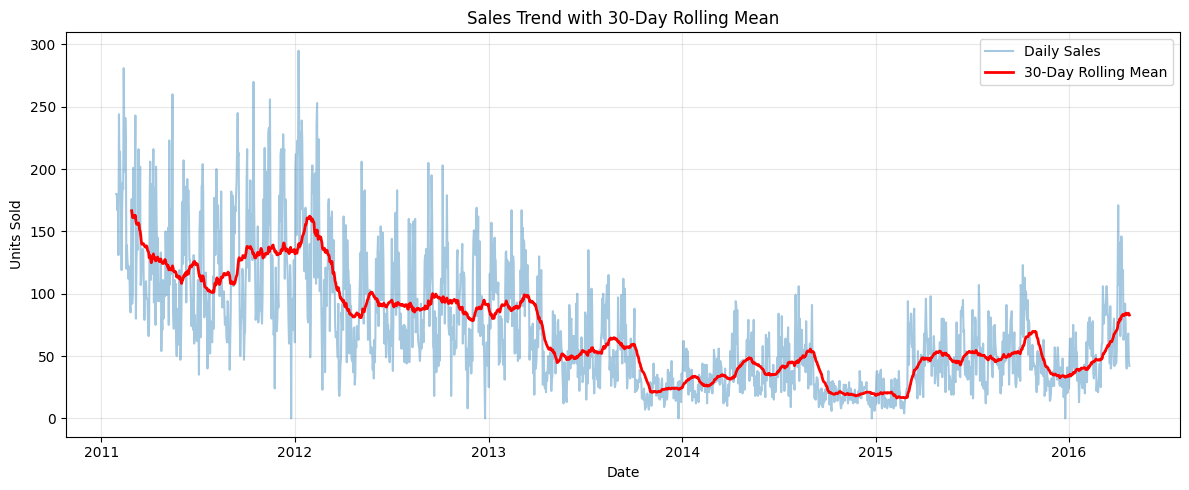

In [ ]:
rolling_30 = daily_sales.rolling(30).mean()

plt.figure(figsize=(12,5))
plt.plot(daily_sales.index, daily_sales.values, alpha=0.4,label='Daily Sales')
plt.plot(rolling_30.index, rolling_30.values,linewidth=2, color='red',label='30-Day Rolling Mean')
plt.title('Sales Trend with 30-Day Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/sales_trend_with_rolling_mean.png")
plt.tight_layout()
plt.show()

## Weekly & Yearly Seasonality


In [ ]:
Sales_df.keys()

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'day_number', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

### Weekly pattern

In [ ]:
# Checking if weekday & number in same order

Weekday = {}
Weekday_number = {}

for i in Sales_df['wday'].unique():
  Weekday = Sales_df[Sales_df['wday']==i]['weekday'].unique()
  Weekday_number = i
  print(f"Weekday {Weekday_number}: {Weekday}")

Weekday 1: ['Saturday']
Weekday 2: ['Sunday']
Weekday 3: ['Monday']
Weekday 4: ['Tuesday']
Weekday 5: ['Wednesday']
Weekday 6: ['Thursday']
Weekday 7: ['Friday']


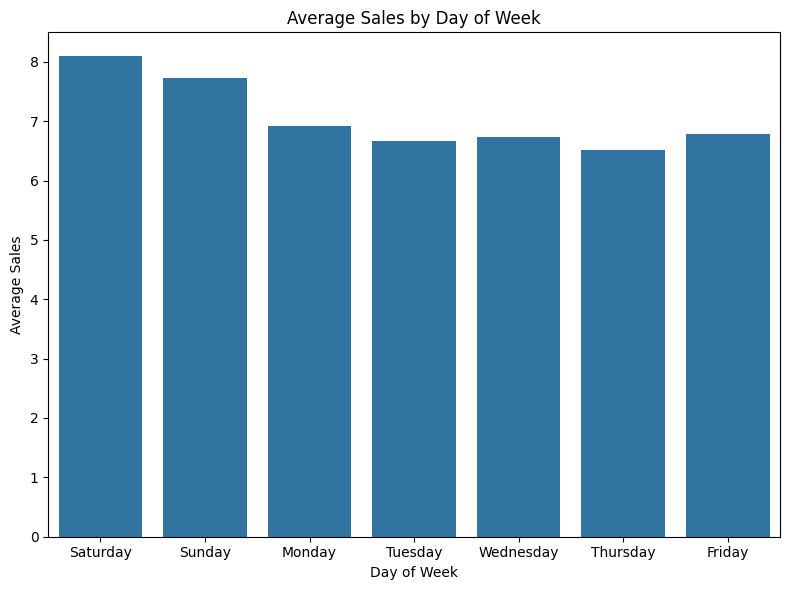

In [ ]:
weekly_pattern = Sales_df.groupby('weekday')['sales'].mean().reindex(Sales_df['weekday']).reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='weekday', y='sales', data=weekly_pattern)
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/average sales by day of week.png")
plt.tight_layout()
plt.show()


### Monthly pattern

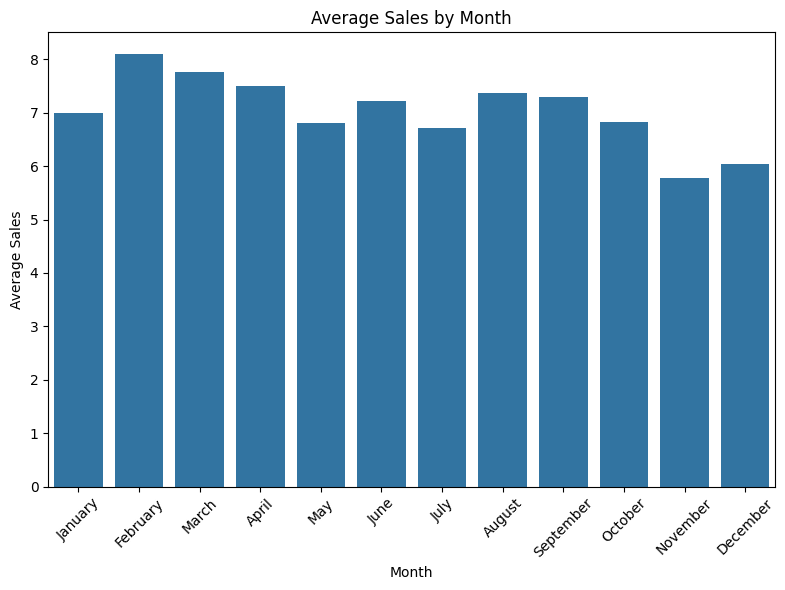

In [ ]:
Sales_df['month_name'] = Sales_df['date'].dt.month_name()

monthly_pattern = Sales_df.groupby('month_name')['sales'].mean().reindex(Sales_df['month_name']).reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='month_name', y='sales', data=monthly_pattern)
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/average sales by month.png")
plt.tight_layout()
plt.show()


## Item level sales Behaviour



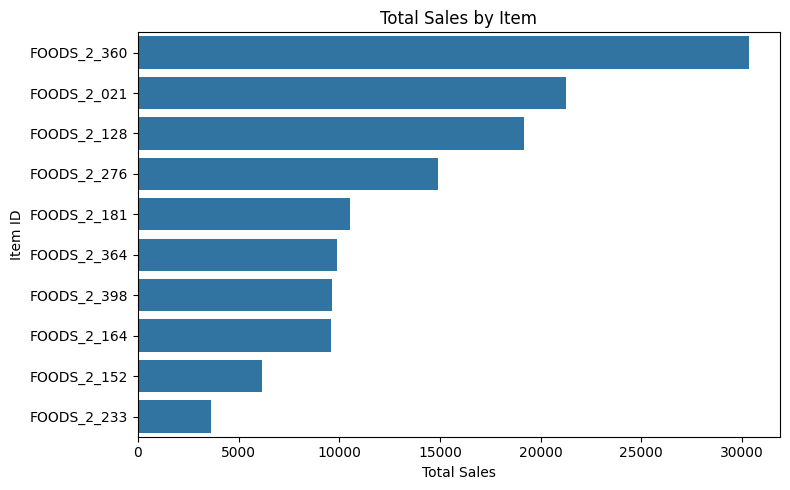

In [ ]:
store_sales = Sales_df.groupby('item_id')['sales'].sum().reset_index()

# Sort in descending order before plotting
store_sales = store_sales.sort_values(by='sales', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='sales', y='item_id', data=store_sales)
plt.title('Total Sales by Item')
plt.xlabel('Total Sales')
plt.ylabel('Item ID')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/total sales by item.png")
plt.tight_layout()
plt.show()

## Price Effect Analysis


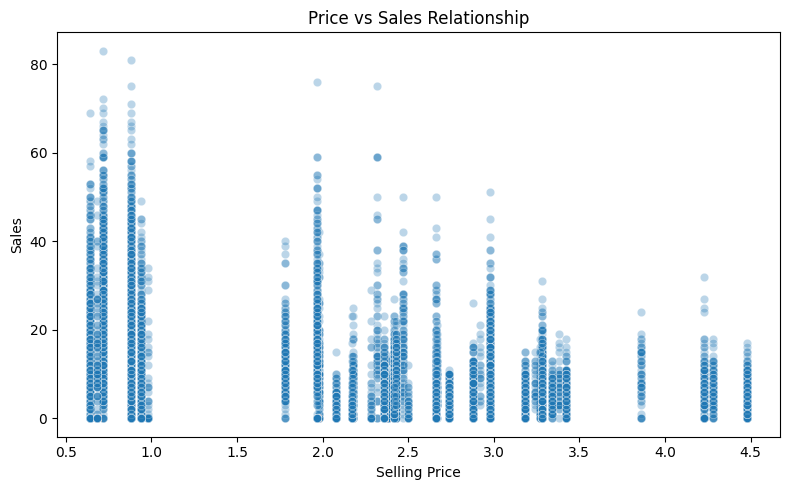

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='sell_price', y='sales', data=Sales_df, alpha=0.3)
plt.title('Price vs Sales Relationship')
plt.xlabel('Selling Price')
plt.ylabel('Sales')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/price vs sales relationship.png")
plt.tight_layout()
plt.show()


## Promotion & Event Impact


### SNAP effect

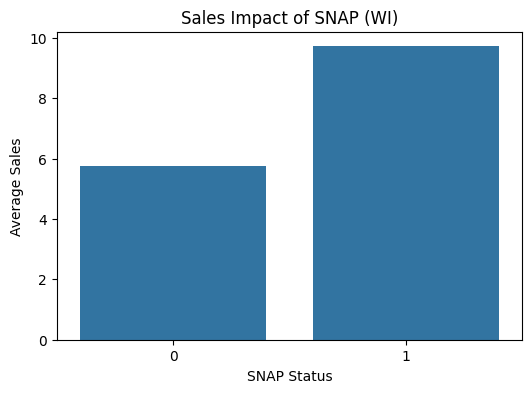

In [ ]:
snap_effect = Sales_df.groupby('snap_WI')['sales'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='snap_WI', y='sales', data=snap_effect)
plt.title('Sales Impact of SNAP (WI)')
plt.xlabel('SNAP Status')
plt.ylabel('Average Sales')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/sales impact of snap (WI).png")
plt.show()


In [ ]:
Sales_df['event_type_1'].unique()

array(['No Event', 'Sporting', 'Cultural', 'National', 'Religious'],
      dtype=object)

In [ ]:
Sales_df['event_name_1'].unique()

array(['No Event', 'SuperBowl', 'ValentinesDay', 'PresidentsDay',
       'LentStart', 'LentWeek2', 'StPatricksDay', 'Purim End',
       'OrthodoxEaster', 'Pesach End', 'Cinco De Mayo', "Mother's day",
       'MemorialDay', 'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

In [ ]:
Sales_df['event_type_2'].unique()

array(['No Event', 'Cultural', 'Religious'], dtype=object)

In [ ]:
Sales_df['event_name_2'].unique()

array(['No Event', 'Easter', 'Cinco De Mayo', 'OrthodoxEaster',
       "Father's day"], dtype=object)

### Events Effect

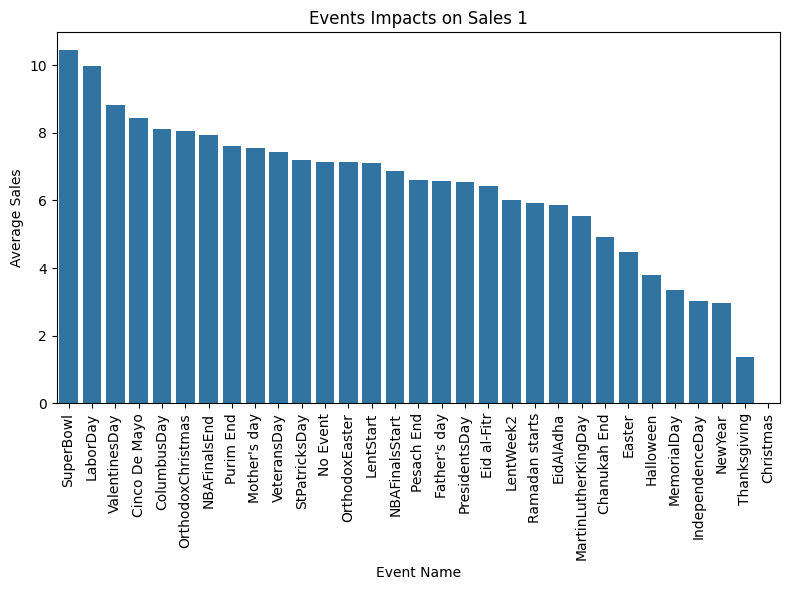

In [ ]:
event_sales = Sales_df.groupby('event_name_1')['sales'].mean().reset_index()

event_sales = event_sales.sort_values(by='sales', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='event_name_1', y='sales', data=event_sales)
plt.title('Events Impacts on Sales 1')
plt.xlabel('Event Name')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Events Impacts on Sales 1.png")
plt.tight_layout()
plt.show()


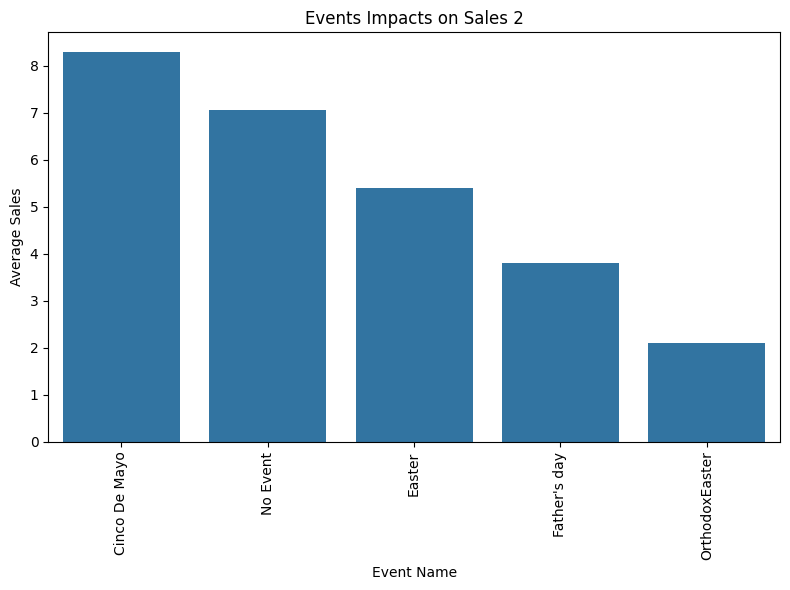

In [ ]:
event_sales = Sales_df.groupby('event_name_2')['sales'].mean().reset_index()

event_sales = event_sales.sort_values(by='sales', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='event_name_2', y='sales', data=event_sales)
plt.title('Events Impacts on Sales 2')
plt.xlabel('Event Name')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Events Impacts on Sales 2.png")
plt.tight_layout()
plt.show()

##Correlation Analysis (Numerical Features)



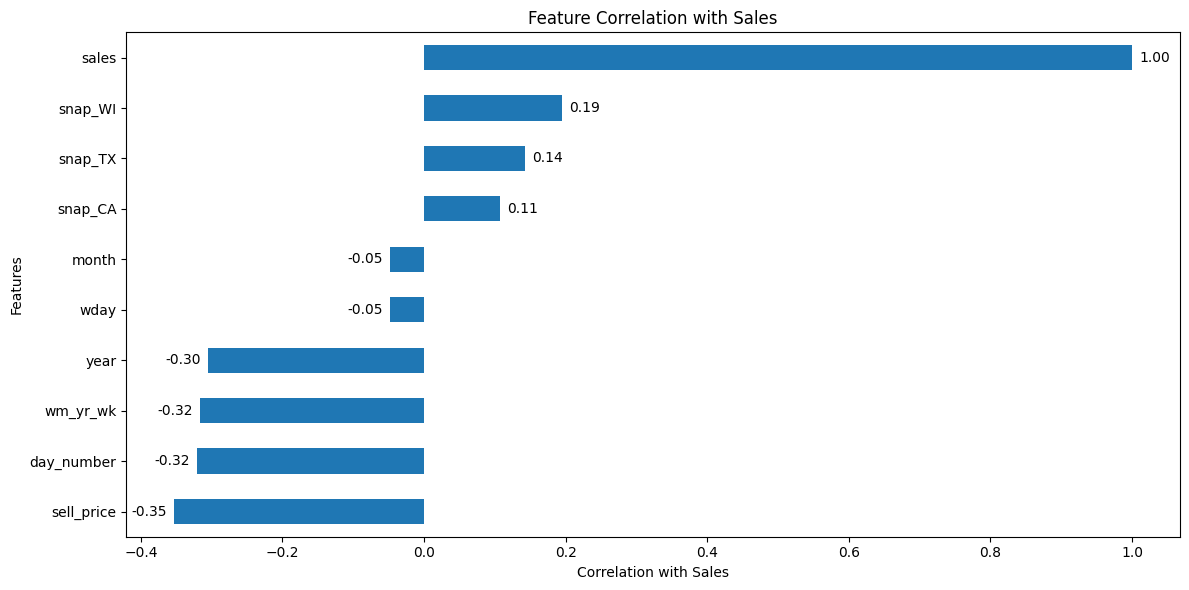

In [ ]:
num_cols = ['sales','sell_price','day_number','wm_yr_wk','wday','month','year','snap_CA','snap_TX','snap_WI']
corr_with_sales = sales_long[num_cols].corr()['sales'].sort_values()

plt.figure(figsize=(12,6))
ax = corr_with_sales.plot(kind='barh')

# Add value labels
for i, v in enumerate(corr_with_sales):
    ax.text(
        v + 0.01 if v > 0 else v - 0.06,  # position
        i,
        f"{v:.2f}",
        va='center'
    )

plt.xlabel('Correlation with Sales')
plt.ylabel('Features')
plt.title('Feature Correlation with Sales')
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/feature_correlation_with_sales.png")
plt.tight_layout()
plt.show()

## Data Preprocessing

### Date & Sorting

In [ ]:
Sales_df['date'] = pd.to_datetime(Sales_df['date'])
Sales_df = Sales_df.sort_values(['item_id', 'date'])

## Model Building

### Gradient Boosting model

In [ ]:
# Keep a copy for  gradient boosting models

df_gb = Sales_df.copy()

### Feature engineering for gradient boosting models

In [ ]:
# Feature engineering

LAGS = [1, 7, 14, 28]

for lag in LAGS:
    df_gb[f"sales_lag_{lag}"] = df_gb.groupby(
        ["item_id"]
    )["sales"].shift(lag)

df_gb["rolling_mean_7"] = df_gb.groupby(
    ["item_id"]
)["sales"].shift(1).rolling(7).mean()

df_gb["rolling_mean_28"] = df_gb.groupby(
    ["item_id"]
)["sales"].shift(1).rolling(28).mean()

df_gb = df_gb.dropna().reset_index(drop=True)


### Feature Selection for Gradient Boosting Models

In [ ]:
# Define target & features

TARGET = "sales"

FEATURES = [
    "day_number", "wday", "month", "year",
    "snap_CA", "snap_TX", "snap_WI",
    "sell_price",
    "sales_lag_1", "sales_lag_7", "sales_lag_14", "sales_lag_28",
    "rolling_mean_7", "rolling_mean_28",
    "item_id", "dept_id", "cat_id",
    "store_id", "state_id",
    "event_name_1", "event_type_1"
]


In [ ]:
# XGBoost, LightGBM need encoding
df_gb_encoding = df_gb.copy()

# CatBoost handles categoricals natively → no encoding needed
df_gb_nonencoding = df_gb.copy()

### Encoding Categorical feature for XGB & LightGBM

In [ ]:
# Encode categorical variables

cat_cols = [
    "item_id", "dept_id", "cat_id",
    "store_id", "state_id",
    "event_name_1", "event_type_1"
]

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_gb_encoding[col] = le.fit_transform(df_gb_encoding[col])
    label_encoders[col] = le


### Train Test Split for XGBoost & LightGBM

In [ ]:
# Train Test spliting for LightGBM,  XGBoost
split_idx = int(len(df_gb_encoding) * 0.8)

train__en = df_gb_encoding.iloc[:split_idx]
valid__en = df_gb_encoding.iloc[split_idx:]

X_train_en = train__en[FEATURES]
y_train_en = train__en[TARGET]

X_valid_en = valid__en[FEATURES]
y_valid_en = valid__en[TARGET]


In [ ]:
cat_cols = [
    "item_id", "dept_id", "cat_id",
    "store_id", "state_id",
    "event_name_1", "event_type_1"
]

### Train Test spliting for CatBoosting

In [ ]:
split_idx = int(len(df_gb_nonencoding) * 0.8)

train_nonen = df_gb_nonencoding.iloc[:split_idx]
valid_nonen = df_gb_nonencoding.iloc[split_idx:]

X_train_nonen = train_nonen[FEATURES]
y_train_nonen = train_nonen[TARGET]

X_valid_nonen = valid_nonen[FEATURES]
y_valid_nonen = valid_nonen[TARGET]

### Creating a function for evaluation metrics

In [ ]:
#  Evaluation metrics
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))
    return rmse, mae, mape, smape


### XGBoost Model Building & training

In [ ]:
# Build Model Parameter
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

# Train Model
xgb.fit(X_train_en, y_train_en)

# Save Model
joblib.dump(xgb, "/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/xgb_model.pkl")

['/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/xgb_model.pkl']

In [ ]:
# Load Model
xgb_loaded = joblib.load("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/xgb_model.pkl")

# Prediction
xgb_preds = xgb_loaded.predict(X_valid_en)

# Get Performance metrics values
xgb_scores = evaluate(y_valid_en, xgb_preds)
print(xgb_scores)

(np.float64(4.977664460205564), 3.92332124710083, np.float64(193.62240033960418), np.float64(90.32991384401706))


### LightGBM Model Building & Training

In [ ]:
# Build Model Parameter
lgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train Model
lgbm.fit(X_train_en, y_train_en)

# Save the model
lgbm.booster_.save_model("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/lgbm_model.txt")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1143
[LightGBM] [Info] Number of data points in the train set: 15080, number of used features: 17
[LightGBM] [Info] Start training from score 7.428979


In [ ]:
# Load Model
loaded_booster = Booster(model_file="/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/lgbm_model.txt")

# Prediction
lgbm_preds = loaded_booster.predict(X_valid_en.values)

# Get performance metrics values
lgbm_scores = evaluate(y_valid_en, lgbm_preds)
print(lgbm_scores)

(np.float64(4.7511507295837925), 3.64767002488033, np.float64(171.77806832180488), np.float64(88.66118874449323))


### CatBoost Model  Building & Training

In [ ]:
# Build CatBoost Model Parameter

cb = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    verbose=50,
    random_seed=42
)

# Train the model
cb.fit(
    X_train_nonen,
    y_train_nonen,
    cat_features=cat_cols
)

# Save the model
cb.save_model("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/catboost_model.cbm")

0:	learn: 9.8506781	total: 23.6ms	remaining: 11.8s
50:	learn: 5.4232737	total: 1.08s	remaining: 9.54s
100:	learn: 5.1050946	total: 2.14s	remaining: 8.44s
150:	learn: 4.9558191	total: 3.15s	remaining: 7.28s
200:	learn: 4.8298113	total: 4.16s	remaining: 6.18s
250:	learn: 4.7098003	total: 5.16s	remaining: 5.12s
300:	learn: 4.5617218	total: 7.2s	remaining: 4.76s
350:	learn: 4.4461402	total: 9.25s	remaining: 3.92s
400:	learn: 4.3552516	total: 10.3s	remaining: 2.53s
450:	learn: 4.2659239	total: 11.2s	remaining: 1.22s
499:	learn: 4.1744116	total: 12.3s	remaining: 0us


In [ ]:
# Load Model
cb_loaded = CatBoostRegressor()
cb_loaded.load_model("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/catboost_model.cbm")

# Prediction
cb_preds = cb_loaded.predict(X_valid_nonen)
cb_scores = evaluate(y_valid_nonen, cb_preds)
print(cb_scores)

(np.float64(3.5684634994537885), 2.5319174467442602, np.float64(100.963506481483), np.float64(81.61185216247448))


### Evaluation Metrics Comparison for Gradient Boosting Models

In [ ]:
# Creating table for all gradient boosting model result

results = pd.DataFrame({
    "Model": ["XGBoost", "LightGBM", "CatBoost"],
    "RMSE": [xgb_scores[0], lgbm_scores[0], cb_scores[0]],
    "MAE": [xgb_scores[1], lgbm_scores[1], cb_scores[1]],
    "MAPE (%)": [xgb_scores[2], lgbm_scores[2], cb_scores[2]],
    "sMAPE (%)": [xgb_scores[3], lgbm_scores[3], cb_scores[3]]
})

results.sort_values("RMSE")

,Model,RMSE,MAE,MAPE (%),sMAPE (%)
2,CatBoost,3.568463,2.531917,100.963506,81.611852
1,LightGBM,4.751151,3.647670,171.778068,88.661189
0,XGBoost,4.977664,3.923321,193.622400,90.329914


### Holt-Winters Model Building & Training

In [ ]:
df_holt_winters = Sales_df.copy()

# Containers
forecast_hw = []
actual_hw = []
eval_hw = []

# Unique items
items_hw = df_holt_winters['item_id'].unique()

for item in items_hw:
    # Prepare time series
    ts = df_holt_winters[df_holt_winters['item_id'] == item].sort_values('date').set_index('date')['sales']

    # log transform for skewed data
    ts_log = np.log1p(ts)

    # Train/test split (last 28 days)
    train, test = ts_log[:-28], ts_log[-28:]

    # Fit Holt-Winters
    model_hw = ExponentialSmoothing(
        train,
        trend='add',
        seasonal='add',
        seasonal_periods=7
    ).fit()

    # Forecast next 28 days
    forecast_log = model_hw.forecast(28)

    # Inverse transform
    forecast = np.expm1(forecast_log)
    actual = np.expm1(test)

    # Store forecasts
    forecast_df = forecast.to_frame(name=item).T
    forecast_df.columns = forecast.index
    forecast_hw.append(forecast_df)

    actual_df = actual.to_frame(name=item).T
    actual_df.columns = actual.index
    actual_hw.append(actual_df)

    # Evaluate using same metrics as CatBoost
    rmse, mae, mape, smape = evaluate(actual, forecast)
    eval_hw.append({
        'item_id': item,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'sMAPE (%)': smape
    })

# Concatenate final output tables
hw_forecast_df = pd.concat(forecast_hw).reset_index(drop=True)
hw_actual_df = pd.concat(actual_hw).reset_index(drop=True)
hw_eval_df = pd.DataFrame(eval_hw).reset_index(drop=True)

# Display evaluation metrics
print(hw_eval_df.head())

       item_id      RMSE       MAE    MAPE (%)   sMAPE (%)
0  FOODS_2_021  6.806383  5.860631  302.927806  113.733688
1  FOODS_2_128  6.090465  4.298915   61.162953   67.445195
2  FOODS_2_152  1.839420  1.504159   56.676084   42.819986
3  FOODS_2_164  4.567387  3.299101   74.409249   70.621442
4  FOODS_2_181  9.532621  7.193747   49.013837   61.287648


### Holt Winter Model Evaluation (Average across items)

In [ ]:
overall_hw_metrics = hw_eval_df[['RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)']].mean()

print("Holt-Winters Overall Performance:\n")
overall_hw_metrics.to_csv("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/overall_hw_metrics'.csv")
overall_hw = pd.DataFrame({
    "Model": ["Holt-Winters"],
    "RMSE": [overall_hw_metrics["RMSE"]],
    "MAE": [overall_hw_metrics["MAE"]],
    "MAPE (%)": [overall_hw_metrics["MAPE (%)"]],
    "sMAPE (%)": [overall_hw_metrics["sMAPE (%)"]]
})

overall_hw

Holt-Winters Overall Performance:



,Model,RMSE,MAE,MAPE (%),sMAPE (%)
0,Holt-Winters,6.144599,4.73881,83.105763,74.126878


## Visualization Forecast vs Actual (Based on one single item)

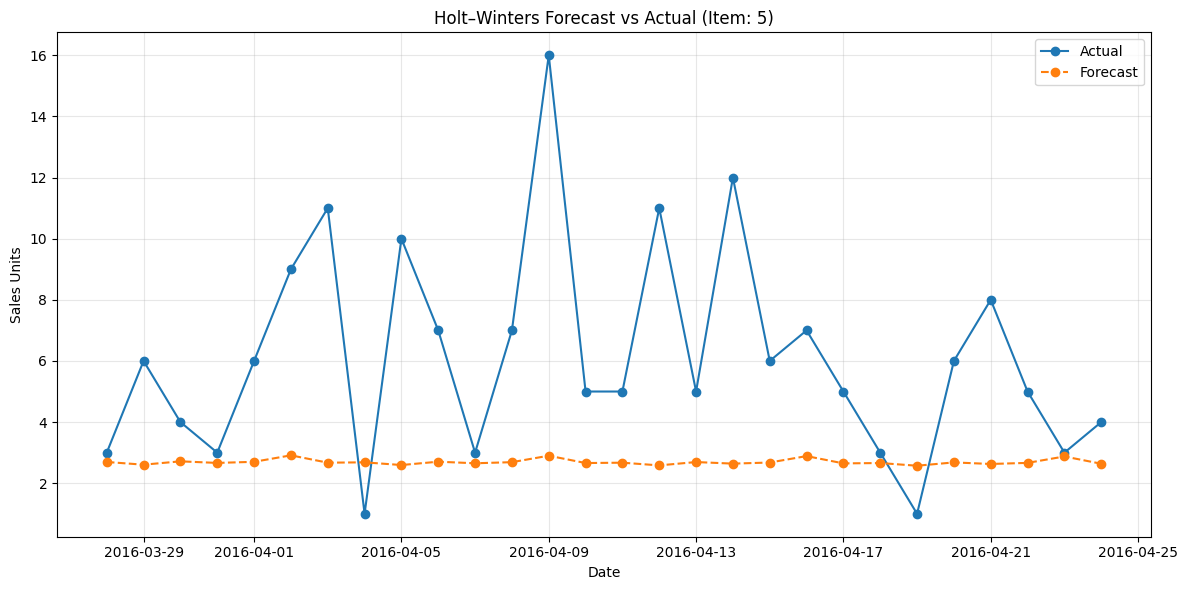

In [ ]:
example_item = hw_forecast_df.index[5]

dates = hw_actual_df.loc[example_item].index  # forecast horizon dates

plt.figure(figsize=(12,6))
plt.plot(dates, hw_actual_df.loc[example_item].values, marker='o', label='Actual')
plt.plot(dates, hw_forecast_df.loc[example_item].values, marker='o', linestyle='--', label='Forecast')

plt.title(f'Holt–Winters Forecast vs Actual (Item: {example_item})')
plt.xlabel('Date')
plt.ylabel('Sales Units')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Holt-Winters Forecast vs Actual.png")
plt.tight_layout()
plt.show()


##SARIMA Model Building & Training

In [ ]:
df_sarima = Sales_df.copy()

# Containers
forecast_sarima = []
actual_sarima = []
eval_sarima = []

# Unique items
items_sarima = df_sarima['item_id'].unique()

for item in items_sarima:
    # Prepare time series
    ts = df_sarima[df_sarima['item_id'] == item].sort_values('date').set_index('date')['sales']

    # log transform to handle skewness
    ts_log = np.log1p(ts)

    # Train/test split (last 28 days)
    train, test = ts_log[:-28], ts_log[-28:]

    # Fit SARIMA model
    model_sarima = SARIMAX(
        train,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # Forecast next 28 days
    forecast_log = model_sarima.forecast(28)

    # Inverse log transform
    forecast = np.expm1(forecast_log)
    actual = np.expm1(test)

    # Store forecasts and actuals
    forecast_df = forecast.to_frame(name=item).T
    forecast_df.columns = forecast.index
    forecast_sarima.append(forecast_df)

    actual_df = actual.to_frame(name=item).T
    actual_df.columns = actual.index
    actual_sarima.append(actual_df)

    # Evaluate using same metrics
    rmse, mae, mape, smape = evaluate(actual, forecast)
    eval_sarima.append({
        'item_id': item,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'sMAPE (%)': smape
    })

# Concatenate final tables
sarima_forecast_df = pd.concat(forecast_sarima).reset_index(drop=True)
sarima_actual_df = pd.concat(actual_sarima).reset_index(drop=True)
sarima_eval_df = pd.DataFrame(eval_sarima).reset_index(drop=True)

# Display first rows of evaluation
sarima_eval_df


,item_id,RMSE,MAE,MAPE (%),sMAPE (%)
0,FOODS_2_021,6.819719,5.860931,286.045212,115.980108
1,FOODS_2_128,6.093243,4.302211,61.188338,67.521521
2,FOODS_2_152,2.021201,1.631425,51.041353,46.927001
3,FOODS_2_164,4.524465,3.263317,74.789845,69.565187
4,FOODS_2_181,9.291531,6.964611,48.363041,58.569999
5,FOODS_2_233,4.521386,3.359991,55.101973,62.529609
6,FOODS_2_276,4.140339,3.406972,62.177945,71.198394
7,FOODS_2_360,13.649053,10.089889,41.696928,48.181841
8,FOODS_2_364,3.715869,3.192953,76.319614,135.402691
9,FOODS_2_398,6.331132,4.895852,48.284717,54.482998


## Sarima Model Evaluation (Average across items)

In [ ]:
# Overall Metrics
overall_sarima_metrics = sarima_eval_df[['RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)']].mean()
overall_sarima_metrics.to_csv("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/overall_sarima_metrics.csv")
overall_sarima = pd.DataFrame({
    "Model": ["Sarima"],
    "RMSE": [overall_sarima_metrics["RMSE"]],
    "MAE": [overall_sarima_metrics["MAE"]],
    "MAPE (%)": [overall_sarima_metrics["MAPE (%)"]],
    "sMAPE (%)": [overall_sarima_metrics["sMAPE (%)"]]
})

overall_sarima

,Model,RMSE,MAE,MAPE (%),sMAPE (%)
0,Sarima,6.110794,4.696815,80.500897,73.035935


## Visualization Forecast vs Actual (Based on one single item)

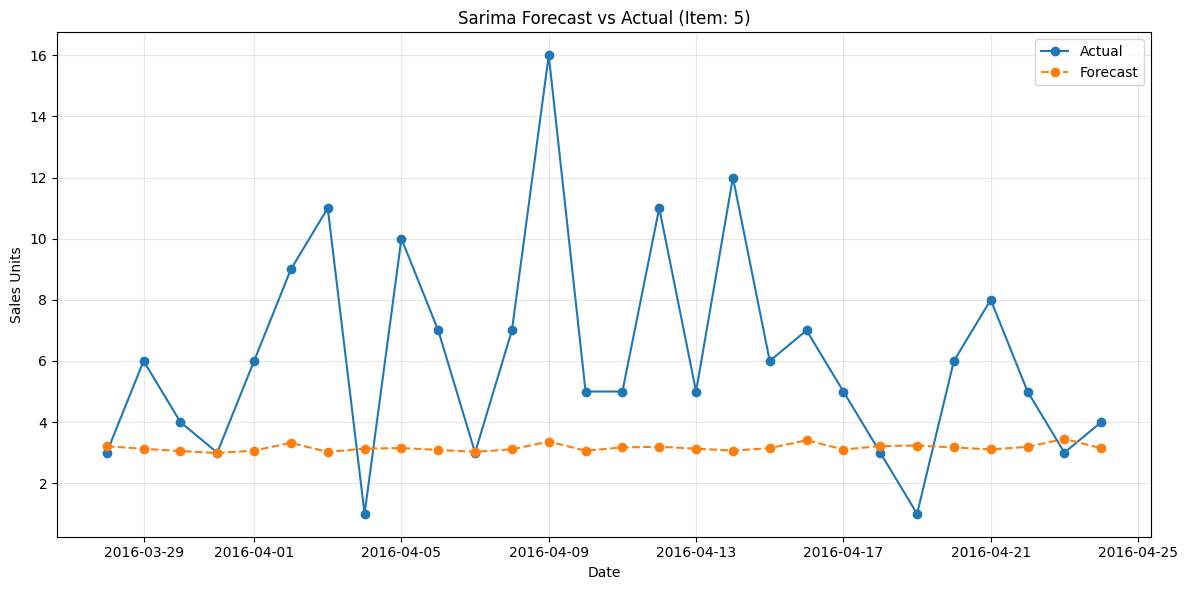

In [ ]:
example_item = sarima_forecast_df.index[5]

dates = sarima_actual_df.loc[example_item].index  # forecast horizon dates

plt.figure(figsize=(12,6))
plt.plot(dates, sarima_actual_df.loc[example_item].values, marker='o', label='Actual')
plt.plot(dates, sarima_forecast_df.loc[example_item].values, marker='o', linestyle='--', label='Forecast')

plt.title(f'Sarima Forecast vs Actual (Item: {example_item})')
plt.xlabel('Date')
plt.ylabel('Sales Units')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Sarima Forecast vs Actual.png")
plt.tight_layout()
plt.show()

###  LSTM Model Building & Training

In [ ]:
df_lstm = Sales_df.copy()

# Containers
lstm_forecast = []
lstm_actual = []
lstm_eval = []

# Sequence generation function
def create_sequences(data, window_size=28):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Unique items
items_lstm = df_lstm['item_id'].unique()

for item in items_lstm:
    ts = df_lstm[df_lstm['item_id']==item].sort_values('date')
    ts = ts.set_index('date')['sales'].values.reshape(-1,1)

    # Log transform
    ts = np.log1p(ts)

    # Normalize
    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(ts)

    # Train/validation split
    train_size = int(len(ts_scaled)*0.8)
    train, val = ts_scaled[:train_size], ts_scaled[train_size:]

    X_train, y_train = create_sequences(train)
    X_val, y_val = create_sequences(val)

    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    # Build LSTM model
    model_lstm = Sequential()
    model_lstm.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1],1)))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer='adam', loss='mse')

    # Train
    history  = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=0)

    # Forecast
    y_pred_scaled = model_lstm.predict(X_val)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_val)

    # Inverse log transform
    y_pred = np.expm1(y_pred)
    y_true = np.expm1(y_true)

    # Store forecast & actual
    forecast_df = pd.DataFrame([y_pred.flatten()], columns=range(1, len(y_pred)+1), index=[item])
    actual_df = pd.DataFrame([y_true.flatten()], columns=range(1, len(y_true)+1), index=[item])
    lstm_forecast.append(forecast_df)
    lstm_actual.append(actual_df)

    # Evaluate
    rmse, mae, mape, smape = evaluate(y_true, y_pred)
    lstm_eval.append({
        'item_id': item,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'sMAPE (%)': smape
    })

# Concatenate final tables
lstm_forecast_table = pd.concat(lstm_forecast).reset_index(drop=True)
lstm_actual_table = pd.concat(lstm_actual).reset_index(drop=True)
lstm_eval_df = pd.DataFrame(lstm_eval).reset_index(drop=True)

# Display evaluation
print(lstm_eval_df.head())

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
       item_id      RMSE       MAE   MAPE (%)   sMAPE (%)
0  FOODS_2_021  4.181932  2.535683  85.408065  117.274725
1  FOODS_2_128  3.918670  2.469083  86.797729  114.434242
2  FOODS_2_152  2.311354  1.652680  76.445339   91.121613
3  FOODS_2_164  3.040056  2.279328  90.826188   82.295438
4  FOODS_2_181  5.069809  3.230434  45.691462  105.717250


##  LSTM Loss

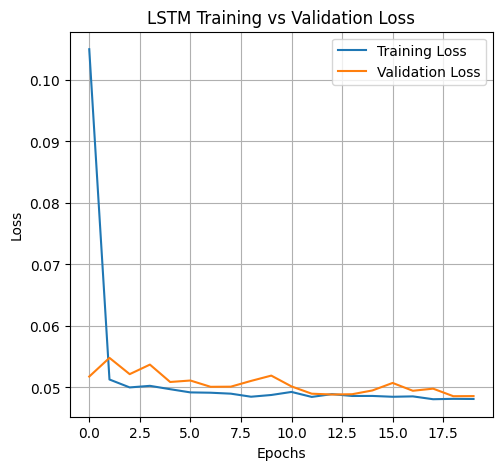

In [ ]:
# Create Figure
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/LSTM Loss.png")
plt.show()

## LSTM Model Evaluation (Average across items)

In [ ]:
overall_lstm_metrics = lstm_eval_df[['RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)']].mean()
overall_lstm_metrics.to_csv('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/overall_lstm_metrics.csv')
overall_lstm = pd.DataFrame({
    "Model": ["LSTM"],
    "RMSE": [overall_lstm_metrics["RMSE"]],
    "MAE": [overall_lstm_metrics["MAE"]],
    "MAPE (%)": [overall_lstm_metrics["MAPE (%)"]],
    "sMAPE (%)": [overall_lstm_metrics["sMAPE (%)"]]
})

overall_lstm

,Model,RMSE,MAE,MAPE (%),sMAPE (%)
0,LSTM,3.968717,2.701508,72.566118,91.196982


## Visualization Forecast vs Actual (Based on one single item)

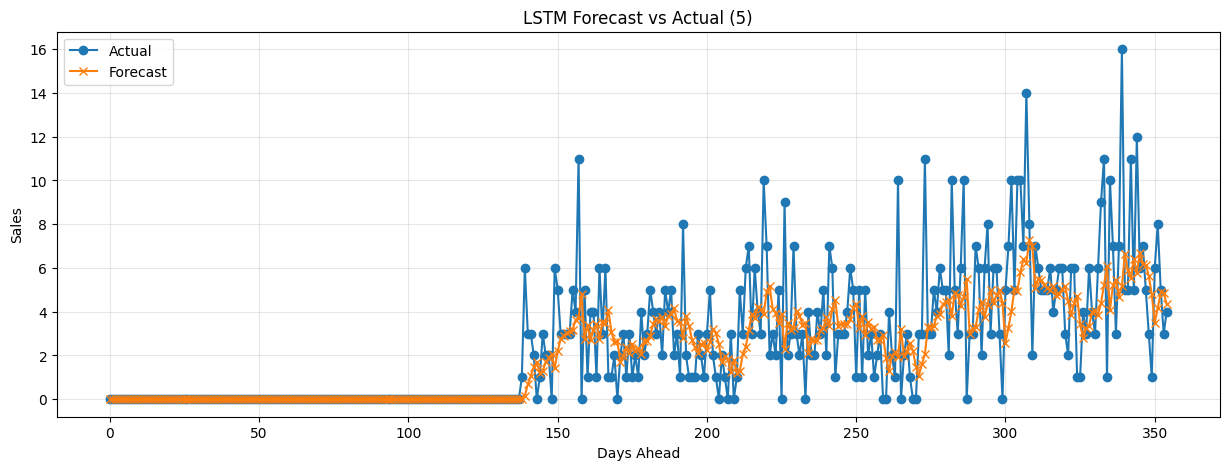

In [ ]:
example_item = lstm_forecast_table.index[5]

plt.figure(figsize=(15,5))
plt.plot(lstm_actual_table.loc[example_item].values, label='Actual', marker='o')
plt.plot(lstm_forecast_table.loc[example_item].values, label='Forecast', marker='x')
plt.title(f'LSTM Forecast vs Actual ({example_item})')
plt.xlabel('Days Ahead')
plt.ylabel('Sales')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/LSTM Forecast vs Actual.png")
plt.show()


### ALL  Models Performance Comparison

In [ ]:
all_models_overall = pd.concat([results, overall_hw,overall_sarima,overall_lstm])

# Sort by RMSE
all_models_overall = all_models_overall.sort_values("RMSE").reset_index(drop=True)

all_models_overall

,Model,RMSE,MAE,MAPE (%),sMAPE (%)
0,CatBoost,3.568463,2.531917,100.963506,81.611852
1,LSTM,3.968717,2.701508,72.566118,91.196982
2,LightGBM,4.751151,3.647670,171.778068,88.661189
3,XGBoost,4.977664,3.923321,193.622400,90.329914
4,Sarima,6.110794,4.696815,80.500897,73.035935
5,Holt-Winters,6.144599,4.738810,83.105763,74.126878


In [ ]:
# Identify best row based on RMSE
best_idx = all_models_overall['RMSE'].idxmin()

# Function to highlight the best row
def highlight_best_row(row):
    return ['background-color: lightgreen; font-weight: bold' if row.name == best_idx else '' for _ in row]

# Apply styling
all_models_overall.style.apply(highlight_best_row, axis=1)


,Model,RMSE,MAE,MAPE (%),sMAPE (%)
0,CatBoost,3.568463,2.531917,100.963506,81.611852
1,LSTM,3.968717,2.701508,72.566118,91.196982
2,LightGBM,4.751151,3.647670,171.778068,88.661189
3,XGBoost,4.977664,3.923321,193.622400,90.329914
4,Sarima,6.110794,4.696815,80.500897,73.035935
5,Holt-Winters,6.144599,4.738810,83.105763,74.126878


### Visualization Model Performance Comparison

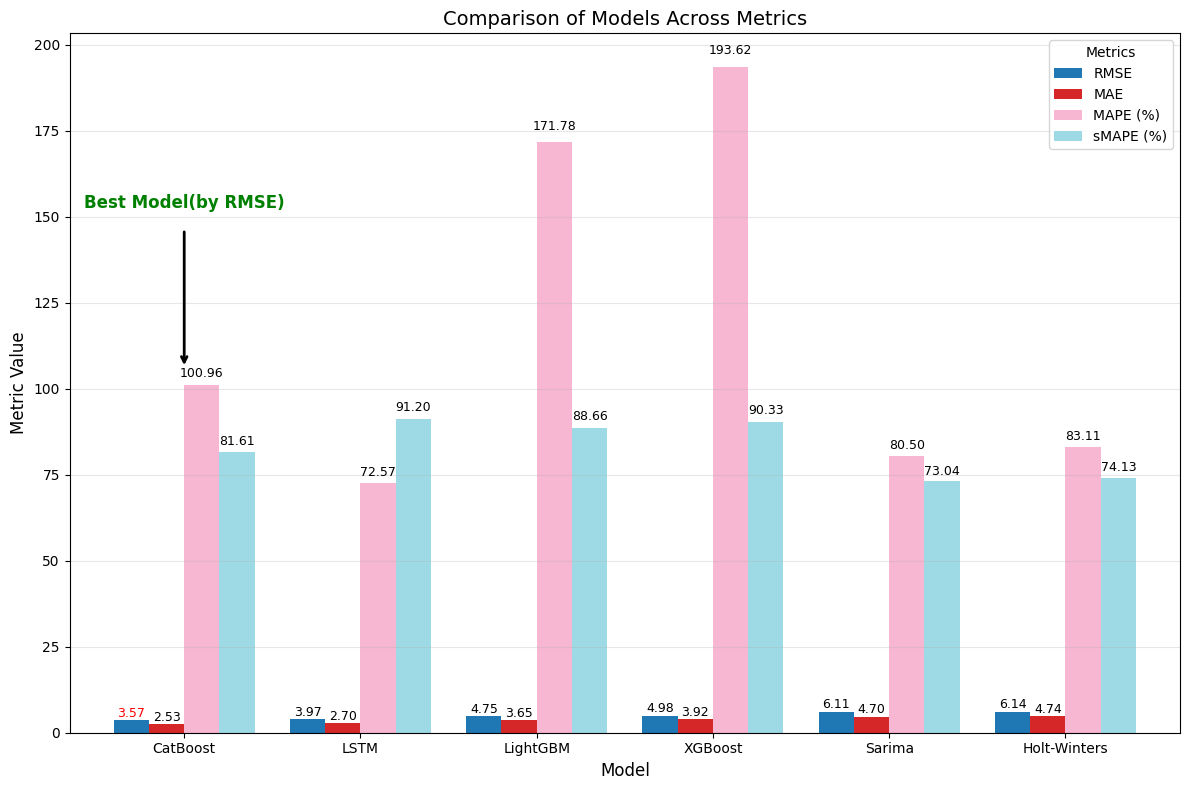

In [ ]:

df_plot = all_models_overall.set_index('Model')[['RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)']]

# Identify best model based on RMSE
best_model = df_plot['RMSE'].idxmin()
best_model_index = list(df_plot.index).index(best_model)

# Create grouped bar chart
ax = df_plot.plot(kind='bar', figsize=(12,8), width=0.8, colormap='tab20')

# Annotate bars
for i, model in enumerate(df_plot.index):
    for j, metric in enumerate(df_plot.columns):
        value = df_plot.loc[model, metric]
        ax.text(
            i + (j-1.5)*0.20,  # adjust x-position for each bar within group
            value + 0.015*value, # slightly above the bar
            f'{value:.2f}',
            ha='center', va='bottom', fontsize=9,
            color='red' if (metric=='RMSE' and model==best_model) else 'black'
        )


max_height = df_plot.loc[best_model].max()
ax.text(
    best_model_index,
    max_height * 1.5,
    'Best Model(by RMSE)',
    ha='center', va='bottom', fontsize=12, fontweight='bold', color='green'
)

# Add arrow pointing to the best model
ax.annotate(
    '',  # no text, just arrow
    xy=(best_model_index, max_height * 1.05),       # point of arrow tip (top of RMSE bar)
    xytext=(best_model_index, max_height * 1.45),  # start of arrow (above the bars)
    arrowprops=dict(facecolor='green', arrowstyle='->', lw=2)
)

# Formatting
plt.title('Comparison of Models Across Metrics', fontsize=14)
plt.ylabel('Metric Value', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Metrics')
plt.tight_layout()

# Save figure
plt.savefig(
    '/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Model_Comparison_BarChart_Annotated_Arrow.png',
    dpi=300
)

plt.show()


## Hyperparameter Tuning for Best Model CatBoost

In [ ]:
def objective(trial):

    params = {
        "iterations": trial.suggest_int("iterations", 300, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 6, 10),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 2),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "random_seed": 42,
        "verbose": 0
    }

    model = CatBoostRegressor(**params)

    model.fit(
        X_train_nonen,
        y_train_nonen,
        cat_features=cat_cols,
        eval_set=(X_valid_nonen, y_valid_nonen),
        early_stopping_rounds=50,
        use_best_model=True
    )

    preds = model.predict(X_valid_nonen)
    rmse = np.sqrt(mean_squared_error(y_valid_nonen, preds))

    return rmse


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print(study.best_params)

[I 2025-12-21 21:18:12,676] A new study created in memory with name: no-name-adef036d-0ace-4b2b-98c7-6054fbf4ac0f
[I 2025-12-21 21:18:40,058] Trial 0 finished with value: 3.582143401031189 and parameters: {'iterations': 756, 'learning_rate': 0.013664617686677523, 'depth': 10, 'l2_leaf_reg': 9, 'bagging_temperature': 1.9949301105978396, 'random_strength': 1, 'min_data_in_leaf': 35}. Best is trial 0 with value: 3.582143401031189.
[I 2025-12-21 21:18:45,055] Trial 1 finished with value: 3.512850565189846 and parameters: {'iterations': 1034, 'learning_rate': 0.019900216705536558, 'depth': 6, 'l2_leaf_reg': 10, 'bagging_temperature': 0.8960824287677864, 'random_strength': 1, 'min_data_in_leaf': 73}. Best is trial 1 with value: 3.512850565189846.
[I 2025-12-21 21:18:57,552] Trial 2 finished with value: 3.5331226439633303 and parameters: {'iterations': 740, 'learning_rate': 0.01438929570971, 'depth': 8, 'l2_leaf_reg': 10, 'bagging_temperature': 0.26470930074825283, 'random_strength': 7, 'min_

{'iterations': 915, 'learning_rate': 0.022259482678250973, 'depth': 6, 'l2_leaf_reg': 5, 'bagging_temperature': 0.4623139988623535, 'random_strength': 3, 'min_data_in_leaf': 88}


In [ ]:
best_params = study.best_params

# Save best params to a JSON file
with open("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/best_cat_params.json", "w") as f:
    json.dump(best_params, f)


In [ ]:
# Load Parameter
with open("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/best_cat_params.json", "r") as f:
    best_params = json.load(f)

Best_params = pd.DataFrame(best_params, index=[0])
Best_params.T

,0
iterations,915.000000
learning_rate,0.022259
depth,6.000000
l2_leaf_reg,5.000000
bagging_temperature,0.462314
random_strength,3.000000
min_data_in_leaf,88.000000


## Re Train CatBoost Model by tuned Parameter

In [ ]:
tuned_model = CatBoostRegressor(
    **best_params,
    loss_function="RMSE",
    random_seed=42,
    verbose=50
)

tuned_model.fit(
    X_train_nonen,
    y_train_nonen,
    cat_features=cat_cols
)


0:	learn: 10.0252342	total: 31.1ms	remaining: 28.4s
50:	learn: 6.5081421	total: 1.4s	remaining: 23.7s
100:	learn: 5.7388022	total: 2.81s	remaining: 22.6s
150:	learn: 5.5409912	total: 3.75s	remaining: 19s
200:	learn: 5.4616801	total: 4.34s	remaining: 15.4s
250:	learn: 5.4179127	total: 4.87s	remaining: 12.9s
300:	learn: 5.3892586	total: 5.39s	remaining: 11s
350:	learn: 5.3627883	total: 5.95s	remaining: 9.55s
400:	learn: 5.3359909	total: 6.48s	remaining: 8.3s
450:	learn: 5.3044690	total: 7.01s	remaining: 7.21s
500:	learn: 5.2673423	total: 7.63s	remaining: 6.3s
550:	learn: 5.2279885	total: 8.21s	remaining: 5.42s
600:	learn: 5.1913443	total: 8.82s	remaining: 4.61s
650:	learn: 5.1623018	total: 9.4s	remaining: 3.81s
700:	learn: 5.1348028	total: 9.98s	remaining: 3.05s
750:	learn: 5.1099284	total: 10.6s	remaining: 2.31s
800:	learn: 5.0815580	total: 11.2s	remaining: 1.59s
850:	learn: 5.0538980	total: 11.7s	remaining: 882ms
900:	learn: 5.0296280	total: 12.3s	remaining: 191ms
914:	learn: 5.0204619

In [ ]:
# Saved Tuned Model
tuned_model.save_model("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/catboost_model_tuned.cbm")


In [ ]:
# Load tuned Model
tuned_model_loaded = CatBoostRegressor()
tuned_model_loaded.load_model("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/catboost_model_tuned.cbm")

cb_preds_tuned = tuned_model_loaded.predict(X_valid_nonen)
cb_scores_tuned = evaluate(y_valid_nonen, cb_preds_tuned)
cb_scores_tuned

(np.float64(3.6177325724930407),
 2.638231604846709,
 np.float64(114.39813446960005),
 np.float64(81.90196567221008))

In [ ]:
results_tuned_comparison = pd.DataFrame({
    "Model": ["CatBoost","CatBoost_tuned"],
    "RMSE": [cb_scores[0],cb_scores_tuned[0]],
    "MAE": [cb_scores[1],cb_scores_tuned[1]],
    "MAPE (%)": [cb_scores[2],cb_scores_tuned[2]],
    "sMAPE (%)": [cb_scores[3],cb_scores_tuned[3]]
})

results_tuned_comparison

,Model,RMSE,MAE,MAPE (%),sMAPE (%)
0,CatBoost,3.568463,2.531917,100.963506,81.611852
1,CatBoost_tuned,3.617733,2.638232,114.398134,81.901966


# Visualization CatBoost before tuning & after tuning

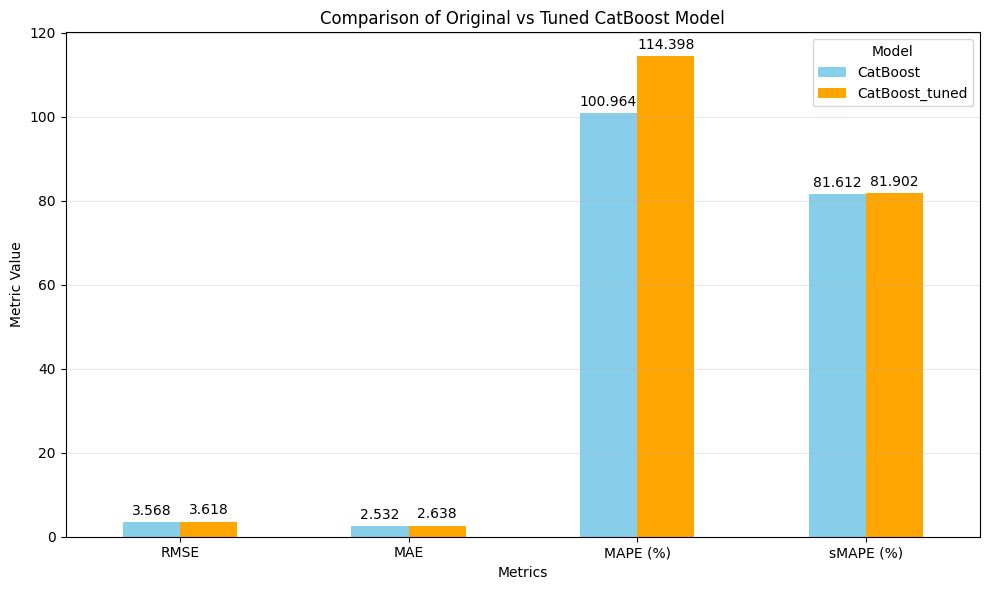

In [ ]:
# Set Model as index
results_tuned_comparison.set_index('Model', inplace=True)

# Transpose for plotting metrics on x-axis
plot_df = results_tuned_comparison.T

# Plot
ax = plot_df.plot(kind='bar', figsize=(10,6), color=['skyblue','orange'])

plt.title('Comparison of Original vs Tuned CatBoost Model')
plt.ylabel('Metric Value')
plt.xlabel('Metrics')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Model')

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()

# Save figure (optional)
plt.savefig(
    "/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/CatBoost_tuned_Metrics_Comparison.png",
    dpi=300
)

plt.show()


### Forecasting for  28 days horizon for item FOODS_2_233

In [ ]:
# Parameters

LEAD_TIME = 5             # days
HOLDING_COST = 0.1        # cost per unit per day
ORDER_COST = 50           # cost per order
SIMULATION_START = '2016-03-28'
SIMULATION_END = '2016-04-24'
ITEM = "FOODS_2_233"     # SKU to forecast
FORECAST_HORIZON = 28     # days


# Features and categorical columns

FEATURES = [
    "day_number", "wday", "month", "year",
    "snap_CA", "snap_TX", "snap_WI",
    "sell_price",
    "sales_lag_1", "sales_lag_7", "sales_lag_14", "sales_lag_28",
    "rolling_mean_7", "rolling_mean_28",
    "item_id", "dept_id", "cat_id",
    "store_id", "state_id",
    "event_name_1", "event_type_1"
]

LAGS = [1, 7, 14, 28]

CAT_FEATURES = ["item_id", "dept_id", "cat_id", "store_id", "state_id", "event_name_1", "event_type_1"]

# Load trained CatBoost model

tuned_model = CatBoostRegressor()
tuned_model.load_model("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Saved Model/catboost_model_tuned.cbm")


# Prepare historical data

history_df = df_gb[df_gb['item_id'] == ITEM].sort_values('date').reset_index(drop=True)

if history_df.empty:
    raise ValueError(f"No historical data found for item {ITEM}")

# Static info
dept_id = history_df['dept_id'].iloc[0]
cat_id = history_df['cat_id'].iloc[0]
store_id = history_df['store_id'].iloc[0]
state_id = history_df['state_id'].iloc[0]
last_price = history_df['sell_price'].iloc[-1]
last_date = history_df['date'].max()


# Create future dataframe for forecast

future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=FORECAST_HORIZON, freq='D')
future_df = pd.DataFrame({
    'date': future_dates,
    'day_number': future_dates.dayofyear,
    'wday': future_dates.dayofweek,
    'month': future_dates.month,
    'year': future_dates.year,
    'item_id': ITEM,
    'dept_id': dept_id,
    'cat_id': cat_id,
    'store_id': store_id,
    'state_id': state_id,
    'snap_CA': 0,
    'snap_TX': 0,
    'snap_WI': 0,
    'sell_price': last_price,
    'event_name_1': "no_event",
    'event_type_1': "no_event"
})


# Initialize sales history

history_sales = history_df['sales'].tolist()


# Recursive forecast loop

for i in range(FORECAST_HORIZON):
    row = future_df.iloc[i].copy()

    # Generate lag features
    for lag in LAGS:
        row[f'sales_lag_{lag}'] = history_sales[-lag] if len(history_sales) >= lag else 0

    # Rolling mean features
    row['rolling_mean_7'] = np.mean(history_sales[-7:]) if len(history_sales) >= 7 else np.mean(history_sales)
    row['rolling_mean_28'] = np.mean(history_sales[-28:]) if len(history_sales) >= 28 else np.mean(history_sales)

    # Prepare input DataFrame
    X_row = row[FEATURES].to_frame().T

    # Ensure categorical columns are strings
    for col in CAT_FEATURES:
        X_row[col] = X_row[col].astype(str)

    # Predict
    pred = tuned_model.predict(X_row)[0]

    # Save forecast
    future_df.loc[i, 'sales'] = pred
    history_sales.append(pred)

forecast_28_days = future_df[['date', 'sales']]
forecast_28_days

,date,sales
0,2016-04-25,2.906519
1,2016-04-26,2.964828
2,2016-04-27,3.094258
3,2016-04-28,3.021798
4,2016-04-29,2.422952
5,2016-04-30,2.196893
6,2016-05-01,2.091675
7,2016-05-02,2.291950
8,2016-05-03,2.229776
9,2016-05-04,2.057614


## Integration of Demand Forecasting & Inventory Policies




### Calculate Inventory KPIs  using CatBoosting Machine Learning Model

In [ ]:
# Inventory Simulation using forecast as demand

inventory = 0
outstanding_orders = []

total_fulfilled = 0
total_unfulfilled = 0
holding_cost = 0
ordering_cost = 0
daily_inventory = []

for idx, current_date in enumerate(forecast_28_days['date']):
    demand = forecast_28_days.loc[idx, 'sales']

    # Receive arriving orders
    arriving_orders = [q for q, arrive_date in outstanding_orders if arrive_date <= current_date]
    if arriving_orders:
        inventory += sum(arriving_orders)
        outstanding_orders = [x for x in outstanding_orders if x[1] > current_date]

    # Fulfill demand
    fulfilled = min(demand, inventory)
    unfulfilled = max(0, demand - inventory)
    inventory -= fulfilled

    # Track KPIs
    total_fulfilled += fulfilled
    total_unfulfilled += unfulfilled
    holding_cost += inventory * HOLDING_COST
    daily_inventory.append(inventory)

    # Forecast-driven ROP / order quantity
    ROP = demand * LEAD_TIME
    order_qty = demand * LEAD_TIME

    if inventory <= ROP:
        arrive_date = current_date + pd.Timedelta(days=LEAD_TIME)
        outstanding_orders.append((order_qty, arrive_date))
        ordering_cost += ORDER_COST


# Compute final KPIs

avg_inventory = np.mean(daily_inventory)
total_demand = total_fulfilled + total_unfulfilled

kpis = pd.DataFrame([{
    'item_id': ITEM,
    'Fill_Rate': total_fulfilled / total_demand if total_demand > 0 else np.nan,
    'Stockout_Rate': total_unfulfilled / total_demand if total_demand > 0 else np.nan,
    'Total_Cost': holding_cost + ordering_cost,
    'Holding_Cost': holding_cost,
    'Ordering_Cost': ordering_cost,
    'Inventory_Turnover': total_fulfilled / avg_inventory if avg_inventory > 0 else np.nan
}])

# Save KPIs
kpis.to_csv("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/kpis_FOODS_2_233_forecast.csv", index=False)

# Display KPIs
kpis

,item_id,Fill_Rate,Stockout_Rate,Total_Cost,Holding_Cost,Ordering_Cost,Inventory_Turnover
0,FOODS_2_233,0.564304,0.435696,363.976135,113.976135,250,0.45851


### Calculate Inventory KPIs by traditional (s, Q) inventory policy or continuous-review fixed reorder point policy

In [ ]:
# Parameters

LEAD_TIME = 5             # lead time in days
HOLDING_COST = 0.1        # cost per unit per day
ORDER_COST = 50           # cost per order
SIMULATION_START = '2016-03-28'
SIMULATION_END = '2016-04-24'
ITEM = "FOODS_2_233"

# Prepare dataset

Sales_df['date'] = pd.to_datetime(Sales_df['date'])

# Filter simulation period and the item
sim_df = Sales_df[(Sales_df['date'] >= SIMULATION_START) &
                  (Sales_df['date'] <= SIMULATION_END) &
                  (Sales_df['item_id'] == ITEM)].copy()

# Long-term mean demand for the item
mean_demand = Sales_df[Sales_df['item_id'] == ITEM]['sales'].mean()

inventory = 0.5 * mean_demand * LEAD_TIME   # initial inventory = 50% of normal ROP
ROP = 0.5 * mean_demand * LEAD_TIME         # reorder point = 50% of normal
order_qty = 0.5 * mean_demand * LEAD_TIME   # order quantity = 50% of normal
outstanding_orders = []                      # list of tuples (qty, arrival_date)

# KPI trackers
total_fulfilled = 0
total_unfulfilled = 0
holding_cost = 0
ordering_cost = 0
daily_inventory = []


# Simulation loop

dates = pd.date_range(SIMULATION_START, SIMULATION_END)

for current_date in dates:
    day_sales = sim_df[sim_df['date'] == current_date]['sales'].sum()

    # Receive orders if lead time passed
    arriving_orders = [q for q, arrive_date in outstanding_orders if arrive_date <= current_date]
    if arriving_orders:
        inventory += sum(arriving_orders)
        outstanding_orders = [x for x in outstanding_orders if x[1] > current_date]

    # Fulfill demand
    fulfilled = min(day_sales, inventory)
    unfulfilled = max(0, day_sales - inventory)
    inventory -= fulfilled

    # Track KPIs
    total_fulfilled += fulfilled
    total_unfulfilled += unfulfilled
    holding_cost += inventory * HOLDING_COST
    daily_inventory.append(inventory)

    # Check ROP and place order if needed
    if inventory <= ROP:
        qty = order_qty
        arrive_date = current_date + pd.Timedelta(days=LEAD_TIME)
        outstanding_orders.append((qty, arrive_date))
        ordering_cost += ORDER_COST

# Compute final KPIs

total_demand = total_fulfilled + total_unfulfilled
avg_inventory = np.mean(daily_inventory)

kpis_foods_2_233 = pd.DataFrame([{
    'item_id': ITEM,
    'Fill_Rate': total_fulfilled / total_demand if total_demand > 0 else np.nan,
    'Stockout_Rate': total_unfulfilled / total_demand if total_demand > 0 else np.nan,
    'Total_Cost': holding_cost + ordering_cost,
    'Holding_Cost': holding_cost,
    'Ordering_Cost': ordering_cost,
    'Inventory_Turnover': total_fulfilled / avg_inventory if avg_inventory > 0 else np.nan
}])

# Save CSV
kpis_foods_2_233.to_csv("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/kpis_foods_2_233_low_fillrate.csv", index=False)

# Display KPIs
kpis_foods_2_233


,item_id,Fill_Rate,Stockout_Rate,Total_Cost,Holding_Cost,Ordering_Cost,Inventory_Turnover
0,FOODS_2_233,0.631732,0.368268,1352.238212,2.238212,1350,135.930822


### Merge KPIs  from Both process

In [ ]:
pd.concat([kpis_foods_2_233, kpis], axis=0)

,item_id,Fill_Rate,Stockout_Rate,Total_Cost,Holding_Cost,Ordering_Cost,Inventory_Turnover
0,FOODS_2_233,0.631732,0.368268,1352.238212,2.238212,1350,135.930822
0,FOODS_2_233,0.564304,0.435696,363.976135,113.976135,250,0.458510


### Visualization for Fill rate (Service Level) & Stock Out comparison traditional vs machine learning

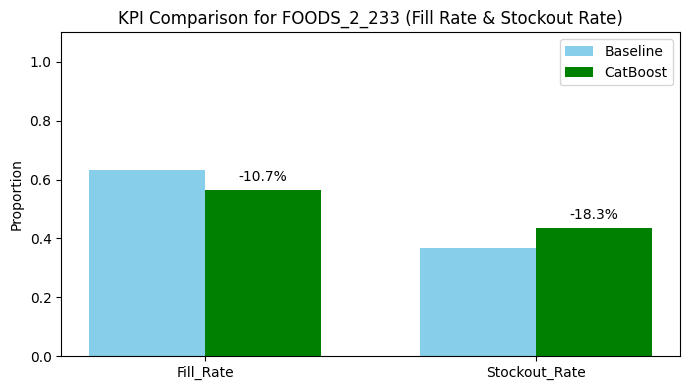

In [ ]:
# Select KPIs to compare

kpis_list = ['Fill_Rate', 'Stockout_Rate']
item_id = 'FOODS_2_233'

# Baseline values
baseline_values = [kpis_foods_2_233.loc[kpis_foods_2_233['item_id'] == item_id, k].values[0] for k in kpis_list]

# CatBoost forecast simulation values
catboost_values = [kpis.loc[kpis['item_id'] == item_id, k].values[0] for k in kpis_list]

# Percentage improvement (CatBoost vs Baseline)

pct_changes = []
for i, kpi in enumerate(kpis_list):
    if kpi == 'Fill_Rate':
        pct_changes.append((catboost_values[i] - baseline_values[i]) / baseline_values[i] * 100 if baseline_values[i] != 0 else 0)
    else:  # Stockout Rate → lower is better
        pct_changes.append((baseline_values[i] - catboost_values[i]) / baseline_values[i] * 100 if baseline_values[i] != 0 else 0)


# Plotting

x = range(len(kpis_list))
width = 0.35

plt.figure(figsize=(7,4))
bars1 = plt.bar(x, baseline_values, width=width, label='Baseline', color='skyblue')
bars2 = plt.bar([i + width for i in x], catboost_values, width=width, label='CatBoost', color='green')

# Add percentage improvement on top of CatBoost bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    change_text = f'{pct_changes[i]:.1f}%'
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, change_text, ha='center', va='bottom', fontsize=10)

plt.xticks([i + width/2 for i in x], kpis_list)
plt.ylabel('Proportion')
plt.title(f'KPI Comparison for {item_id} (Fill Rate & Stockout Rate)')
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/KPI_Comparison_Fill_Stockout.png")
plt.show()


## Visualization for Cost & Inventory KPIs Comparison Traditional vs Machine Learning

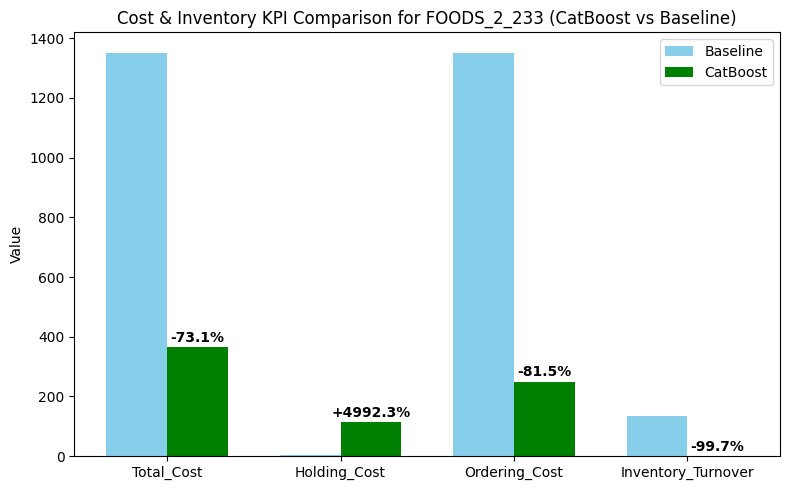

In [ ]:
# Prepare comparison dataframe

baseline_kpis = kpis_foods_2_233.copy()
baseline_kpis = baseline_kpis.rename(columns={
    'Total_Cost': 'Total_Cost_baseline',
    'Holding_Cost': 'Holding_Cost_baseline',
    'Ordering_Cost': 'Ordering_Cost_baseline',
    'Inventory_Turnover': 'Inventory_Turnover_baseline'
})

# CatBoost KPIs (from forecast-driven simulation)
catboost_kpis = kpis.copy()
catboost_kpis = catboost_kpis.rename(columns={
    'Total_Cost': 'Total_Cost_catboost',
    'Holding_Cost': 'Holding_Cost_catboost',
    'Ordering_Cost': 'Ordering_Cost_catboost',
    'Inventory_Turnover': 'Inventory_Turnover_catboost'
})

# Merge baseline and CatBoost KPIs
comparison = pd.merge(baseline_kpis, catboost_kpis, on='item_id', how='inner')

# Compute difference and % change for cost/inventory KPIs

kpi_cols = ['Total_Cost', 'Holding_Cost', 'Ordering_Cost', 'Inventory_Turnover']
for col in kpi_cols:
    comparison[f'{col}_diff'] = comparison[f'{col}_catboost'] - comparison[f'{col}_baseline']
    comparison[f'{col}_pct_change'] = (comparison[f'{col}_diff'] / comparison[f'{col}_baseline']) * 100


# Select the item FOODS_2_233

item_cost_kpis = comparison[comparison['item_id'] == 'FOODS_2_233']

# Select only relevant columns
cols_to_show = ['item_id']
for kpi in kpi_cols:
    cols_to_show += [f'{kpi}_baseline', f'{kpi}_catboost', f'{kpi}_diff', f'{kpi}_pct_change']

item_cost_kpis = item_cost_kpis[cols_to_show]

# Save CSV
item_cost_kpis.to_csv('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Cost_KPI_Comparison_CatBoost.csv', index=False)


# Plot Cost & Inventory KPI Comparison

item_data = item_cost_kpis.iloc[0]
baseline_values = [item_data[f'{kpi}_baseline'] for kpi in kpi_cols]
catboost_values = [item_data[f'{kpi}_catboost'] for kpi in kpi_cols]
pct_changes = [item_data[f'{kpi}_pct_change'] for kpi in kpi_cols]

x = np.arange(len(kpi_cols))
width = 0.35

plt.figure(figsize=(8,5))
bars1 = plt.bar(x - width/2, baseline_values, width, label='Baseline', color='skyblue')
bars2 = plt.bar(x + width/2, catboost_values, width, label='CatBoost', color='green')

# Annotate % change on top of CatBoost bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    sign = '+' if pct_changes[i] >= 0 else ''
    plt.text(bar.get_x() + bar.get_width()/2, height + max(catboost_values)*0.02,
             f'{sign}{pct_changes[i]:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(x, kpi_cols)
plt.ylabel('Value')
plt.title(f'Cost & Inventory KPI Comparison for {item_data["item_id"]} (CatBoost vs Baseline)')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/2nd Year/Semester A/Data Science Project/Generated Graph & Table/Cost_Inventory_KPI_Comparison_CatBoost.png')
plt.show()
